# Neural Networks and Deep Learning A.Y. 2022/2023
## Final Project: 3D Objects Classification

Group members:<br>
* *Candon Matteo 2020353*: ICT for Internet and Multimedia (Cybersystems) <br>
* *Nicoletti Gianpietro 2053042*: ICT for Internet and Multimedia (Cybersystems) <br>
* *Rizzetto Nicola 2052417*: Computer Engineering (Artificial Intelligence and Robotics) <br>

## Initial configuration and import of the libraries

In [4]:
#Platform settings: this is an automatinc decision so, please, don't change the value
COLAB = True

try:
    from google.colab import drive
except:
    COLAB = False
    

#Dataset settings:
LOAD_DATASET = True #True if you want to load a precomputed dataset 
ALREADY_DOWNLOADED = False #True if you have already the dataset in the memory
ALREADY_UNZIPPED = False #True if you have already unzipped the dataset in the ./data folder, IF True the value of
                        #ALREADY_DOWNLOADED variable will be ignore

#Model settings:
LOAD_MODEL = False #True if you want load the trained model for XX epochs

In [5]:
PURPLE = '\033[95m'
CYAN = '\033[96m'
DARKCYAN = '\033[36m'
BLUE = '\033[94m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
RED = '\033[91m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

In [6]:
#if working with colab these are needed
if (COLAB):
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git


    !pip install tensorflow
    !pip install trimesh
    !pip install open3d
    
import trimesh # useful to load polygonal objects (off files)
import glob # useful to read filenames with specific patterns, i.e. chair_****
import open3d

# Neural Networks libraries
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import MulticlassAccuracy
from torch_geometric.nn import GCNConv,global_max_pool
from torch.optim.lr_scheduler import StepLR

#graph libraries
from sklearn.neighbors import kneighbors_graph
import networkx as nx



import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import time # used to check the training duration
import math
from sklearn.utils import shuffle

#manual set of seed for reproducibility
seed = 353
tf.random.set_seed(seed)


from tqdm import tqdm, trange
import gc

import os
import collections
import urllib.request
import zipfile

Found existing installation: torch-geometric 2.2.0
Uninstalling torch-geometric-2.2.0:
  Successfully uninstalled torch-geometric-2.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 36.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/p

## Utility functions definition

**NOTES**:

**In order to avoid missing classes you need to go to the directory where the dataset is and remove the unused file in the main directory of the dataset**

In [7]:
#usefull functions

cloud_points = 2048 #number of points to describe an object

def dataset(points = cloud_points):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    classes_map = {}
    
    #saving all classes' folder paths in list
    folders = [dir for dir in sorted(os.listdir(data_dir))if os.path.isdir(data_dir)]
    folders_path=[]
    for i in range(10):
        folders_path.append(glob.glob(os.path.join(data_dir, folders[i])))
        
        
    for i,folder in enumerate(folders_path):
        
        #storing classes' names into list
        
        print(i)
        print(folder[0])
        print(type(folder[0]))
        
        classes_map[i] = folder[0].split("\\")[-1]
        
        #storing train and test files
        train_files = glob.glob(os.path.join(folder[0], "train/*"))
        test_files = glob.glob(os.path.join(folder[0], "test/*"))
        
        #converting train and test files in cloud points
        for j in train_files:
            train_points.append(trimesh.load(j).sample(cloud_points))
            train_labels.append(i)

        for j in test_files:
            test_points.append(trimesh.load(j).sample(cloud_points))
            test_labels.append(i)

    return (np.array(train_points),
            np.array(test_points),
            np.array(train_labels),
            np.array(test_labels),
            classes_map)



def add_normals(points_array):
    tmp = []
    for i in trange(len(points_array)):
        pcd = open3d.geometry.PointCloud()
        pcd.points = open3d.utility.Vector3dVector(points_array[i])

        pcd.estimate_normals(search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=250, max_nn=200))


        tmp.append(np.concatenate((np.asarray(pcd.points),np.asarray(pcd.normals)),axis=1).astype(np.float64))

    return tmp


def build_graph(data_points):
    
    edges = []
    
    for i in trange(len(data_points)):
        
        A = kneighbors_graph(data_points[i],mode='distance', n_neighbors = 50).toarray()
        indices = np.argpartition(A, 50, axis=1)[:, :50]
        edge_indexes = np.stack([np.repeat(np.arange(data_points[i].shape[0]), 50), indices.flatten()])
#         A = nx.from_numpy_array(A)
#         edges.append(np.asarray(list(A.edges())).T)
        edges.append(edge_indexes)
        print(edge_indexes.shape)
        
        del A
        del edge_indexes
        del indices
        gc.collect()
    
    return edges

## Creating or loading the dataset

2048 points: https://www.dropbox.com/s/t5h5nmphju4ni14/dataset_nndl_2048.zip?dl=1 <br>

**NOTES:**
* dl=1 : force the download of the file;
* In order to select the correct dataset you need only to modify the url in the method `urlretrieve(url,name)`
* Remember to change the value of `cloud_points` according to the datasets you want use

In [8]:
if(LOAD_DATASET):
    
    cloud_points = 2048
    
    if(not ALREADY_DOWNLOADED and (not ALREADY_UNZIPPED)):
        urllib.request.urlretrieve("https://www.dropbox.com/s/t5h5nmphju4ni14/dataset_nndl_2048.zip?dl=1", "dataset_nndl.zip")
        
    if(not ALREADY_UNZIPPED):
        with zipfile.ZipFile("dataset_nndl.zip", 'r') as zip_ref:
            zip_ref.extractall("./data/")
        
    #loading the data
    data_train = np.load("data/train_data.npy",allow_pickle=True)
    data_test = np.load("data/test_data.npy",allow_pickle=True)
    edge_train = np.load("data/train_edges.npy",allow_pickle=True)
    edge_test = np.load("data/test_edges.npy",allow_pickle=True)
    train_labels = np.load("data/train_labels.npy",allow_pickle=True)
    test_labels = np.load("data/test_labels.npy",allow_pickle=True)

In [9]:
if(not LOAD_DATASET):
    data_dir = tf.keras.utils.get_file("modelnet.zip", "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip", extract = True)
    data_dir = os.path.join(os.path.dirname(data_dir), "ModelNet10")

#each class is already divided in train and test data

In [10]:
#Visualization of data example
if(not LOAD_DATASET):
    mesh = trimesh.load(os.path.join(data_dir,"chair/train/chair_0003.off"))
    mesh.show()

In [11]:
if(not LOAD_DATASET):
    #setting parameters
    classes = 10 #number of different kind of objects - non modifiable

    # Creating dataset object
    data_start_time = time.time()
    train_points, test_points, train_labels, test_labels, classes_map = dataset(cloud_points)
    data_end_time = time.time()

    print("Time spent creating the dataset object: ",np.round((data_end_time - data_start_time)/60,2), " minutes.")

In [12]:
if(not LOAD_DATASET):
    
    print(len(train_points))
    print(len(test_points))

    data_train = add_normals(train_points)
    data_test = add_normals(test_points)

    edge_train=build_graph(train_points)
    edge_test=build_graph(test_points)

    
    #removing usless variables to clean the RAM
    del train_points
    del test_points
    gc.collect()

**From now on the data contained in each point is: (X , Y , Z , $N_x$ , $N_y$ , $N_z$)** i.e: position + normal vector

### Saving the dataset into local memory

**NOTES:**

If you want create a link to be used in this code, compress the .npy files into a single .zip file.<br>
Make sure that the structure of the .zip will be:<br>
<br>
folder.zip<br>
--file1.npy<br>
--file2.npy<br>
-- ...<br>

<br>
and not something like:<br>
<br>
folder.zip<br>
--inner folder<br>
----file1.npy<br>
----file2.npy<br>
---- ...
<br>
<br>
Mantain these names:

* list of points for the train: train_data.npy
* list of points for the test: test_data.npy
* list of edges for the train: train_edges.npy
* list of edges for the test: test_edges.npy
* labels for the train: train_labels.npy
* labels for the test: test_labels.npy

In [13]:
if(not LOAD_DATASET):
    #list of arrays to array of arrays
    train = np.empty(len(edge_train), object)
    train[:] = edge_train
    test = np.empty(len(edge_test), object)
    test[:] = edge_test
    
    #saving the data
    np.save("data/train_data.npy",data_train)
    np.save("data/test_data.npy",data_test)
    np.save("data/train_edges.npy",train)
    np.save("data/test_edges.npy",test)
    np.save("data/train_labels.npy",train_labels)
    np.save("data/test_labels.npy",test_labels)

### Example of the dataset with and without normal vectors

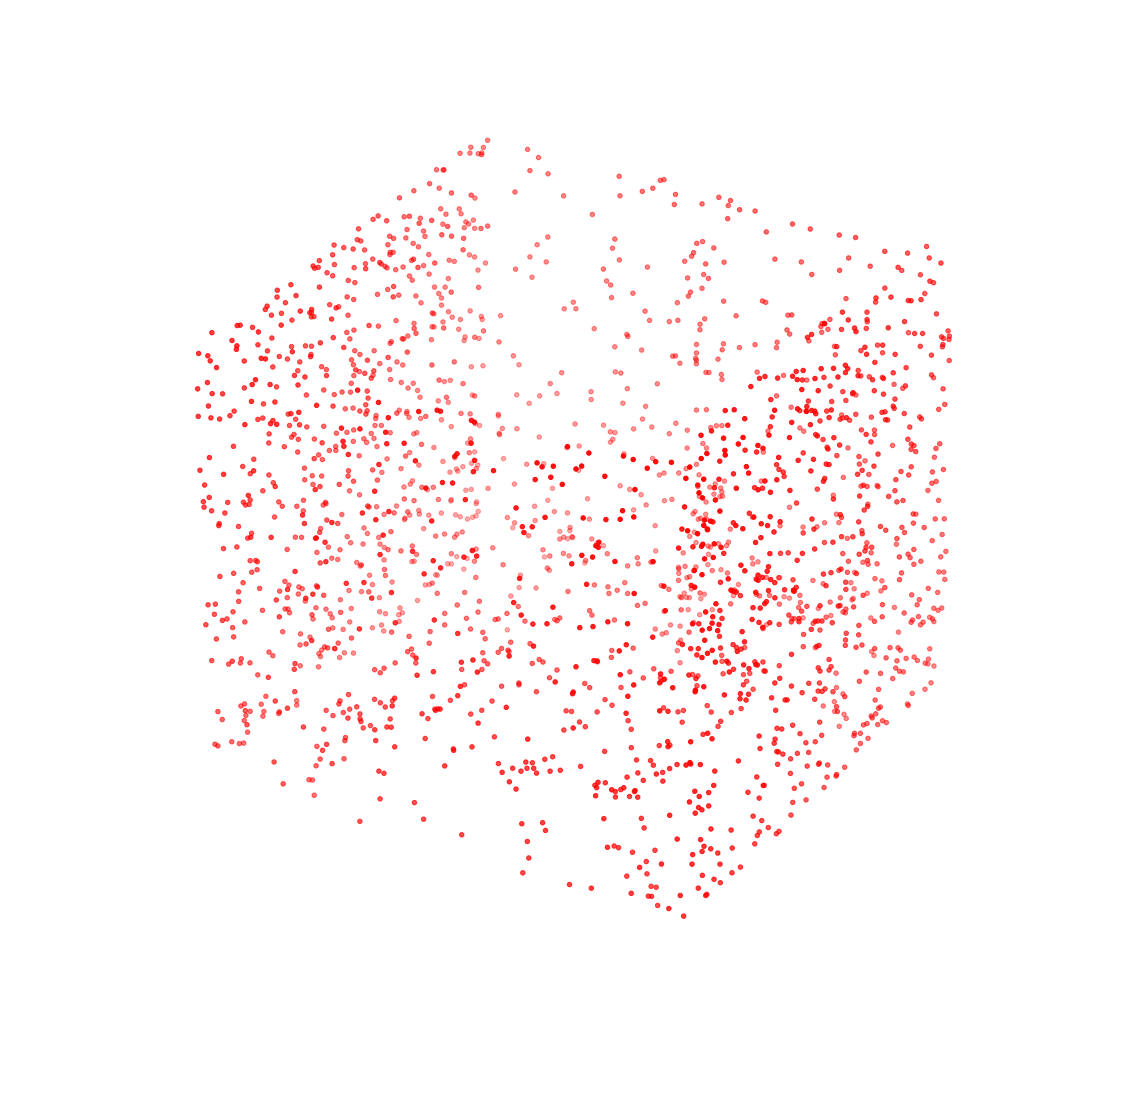

In [14]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(data_train[2][:, 0], data_train[2][:, 1], data_train[2][:, 2],color='r')
ax.set_axis_off()

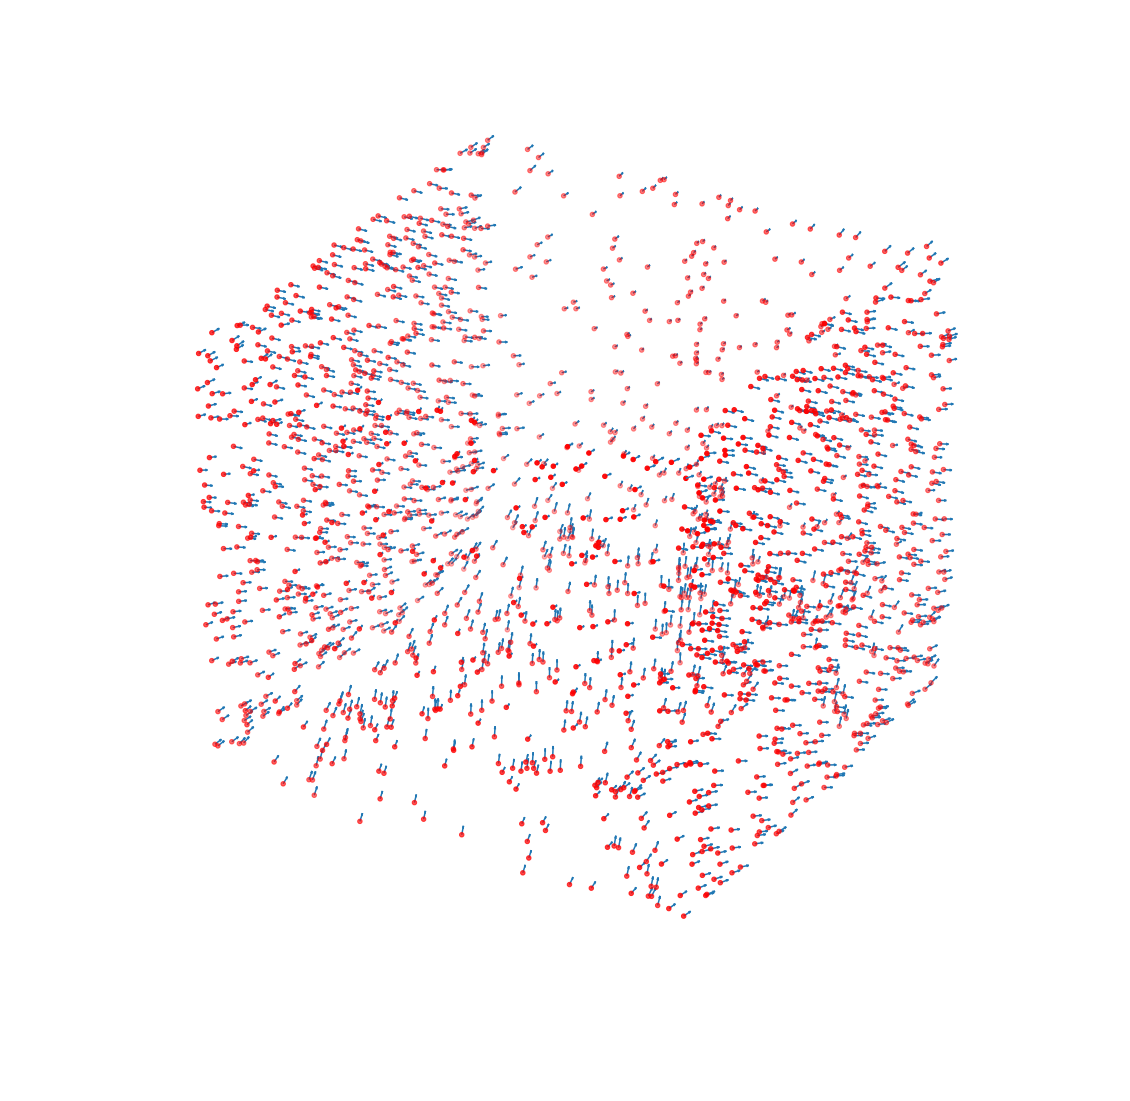

In [15]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(data_train[2][:, 0], data_train[2][:, 1], data_train[2][:, 2],color='r')
ax.set_axis_off()

for element in data_train[2]:
  x=element[0]
  y=element[1]
  z=element[2]
  u=abs(element[3])
  v=abs(element[4])
  w=abs(element[5])
  ax.quiver(x, y, z, u, v, w, length=0.5, normalize=True, alpha = 1)

## Graph Convolutional Network

### Shuffle and data augmentation

In [16]:
torch.cuda.empty_cache()
gc.collect()

23

In [17]:
#shuffle of the original data
indexes =[i for i in range(len(train_labels))]
import random
random.shuffle(indexes)

data_train = data_train[indexes]
train_labels = train_labels[indexes]
edge_train = edge_train[indexes]

In [18]:
#data augmentation: i.e. adding noise to the data(poistion + normal) but mainaining the same graph and label.
# in this case we obtain 3x samples of the original dataset
data_train_noise = np.concatenate((data_train,data_train+normal(0,5,size = (len(data_train),2048,6))),axis=0)
train_labels_noise = np.concatenate((train_labels,train_labels),axis=0)
edge_train_noise =  np.concatenate((edge_train,edge_train),axis=0)

In [19]:
#shuffle of the augmented dataset
indexes =[i for i in range(len(train_labels_noise))]
import random
random.shuffle(indexes)

data_train_noise = data_train_noise[indexes]
train_labels_noise = train_labels_noise[indexes]
edge_train_noise = edge_train_noise[indexes]

In [20]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# for i in range(len(train_labels)):
#     data_train_noise[i] = scaler.fit_transform(data_train_noise[i])
    
# for i in range(len(test_labels)):
#     data_test[i] = scaler.fit_transform(data_test[i])

In [21]:
# "one-hot encoding": in this case we want to maximize a specific position inside the array that rappresents the label of
#the sample. 
one_labels_train = []
for label in train_labels_noise:
    array = np.zeros(10)
    array[label] = 1000
    one_labels_train.append(array)

### Training

In [22]:
class ListDataset(Dataset):
    def __init__(self, data, edges, labels):
        self.data = data
        self.edges = edges
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.edges[index]), torch.tensor(self.labels[index])

    def __len__(self):
        return len(self.data)

train_dataset = ListDataset(data_train_noise[0:7000], edge_train_noise[0:7000], one_labels_train[0:7000])
val_dataset = ListDataset(data_train_noise[7000:len(data_train_noise)], edge_train_noise[7000:len(data_train_noise)], one_labels_train[7000:len(data_train_noise)])


train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = False)

In [27]:
class MLPpos(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.fc1 = nn.Linear(81, 27)
        self.fc2 = nn.Linear(27,9)
        self.act = nn.LeakyReLU()
    
        
    def forward(self, x):
       
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x
    
class MLPnorm(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.fc1 = nn.Linear(81, 27)
        self.fc2 = nn.Linear(27,9)
        self.act = nn.LeakyReLU()
    
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        
        return x

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        # Define the graph convolutional layers
        self.conv1 = GCNConv(3, 27)
        self.conv2 = GCNConv(27, 81)
       
        
        self.conv3 = GCNConv(3, 27)
        self.conv4 = GCNConv(27, 81)
        
        #compressing the point features
        self.mlppos = MLPpos()
        self.mlpnorm = MLPnorm()
        
        # Define the final fully-connected layer
        #self.fc1 = nn.Linear(18*cloud_points,400)
        self.fc2 = nn.Linear(900,50)
        self.fc3 = nn.Linear(50,num_classes)
        
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.avgpool = nn.AvgPool2d(kernel_size = 5, stride = 2)
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.25)
        
    def forward(self, x, edge_index):
        # Apply the graph convolutional layers
        
        pos = self.relu(self.conv1(x[:,0:3],edge_index))
        pos = self.relu(self.conv2(pos,edge_index))
        pos = self.drop(self.relu(self.mlppos(pos)))
        pos = self.maxpool(pos)
        
        norm = self.relu(self.conv3(x[:,3:6],edge_index))
        norm = self.relu(self.conv4(norm,edge_index))
        norm = self.drop(self.relu(self.mlpnorm(norm)))
        norm = self.maxpool(norm)

        # Apply the final fully-connected layer
        xl = torch.cat((pos,norm), 1)
        xl = torch.reshape(xl, (1,64,64))
        xl = self.avgpool(xl)
        xl = torch.flatten(xl)
        #xl = self.relu(self.drop(self.fc1(xl)))
        xl = self.relu(self.drop(self.fc2(xl)))
        xl = self.drop(self.fc3(xl))
        
        return xl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net =  Net(num_classes=10).to(device)

print(BOLD+"You are working on: "+END+str(device))

You are working on: cuda


In [28]:
#training only if you decide to not load the model    
if(not LOAD_MODEL):
    
    num_epochs = 30
    loss_fn = nn.MSELoss()

    optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-2)
    optimizer.param_groups[0]['capturable'] = False
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    #lists to store the trend of the learning procedure
    plot_train = []
    plot_val=[]


    best_epoch_val = 0
    prev_loss_val = np.inf


    best_epoch_train = 0
    prev_loss_train = np.inf

    count_epochs = 0 #counts the epoch since we consider the fact we can manually interrupct the 
                     #training procedure(used for the plots)

    for epoch in range(num_epochs):

        print('#################')
        print(f'# EPOCH {epoch+1}')
        print('#################')



        #lists to store the trend of the learning procedure "in real time" at each epoch/batch
        train_loss = []
        val_loss = []
        batch_loss = []

        ##############TRAINING##############

        net.train()

        input_counter = 0
        counter = 0

        optimizer.zero_grad()

        iterator = tqdm(train_dataloader)    
        for sample in iterator:
            data = sample[0][0].float().to(device)
            edges = sample[1][0].long().to(device)
            labels = sample[2].float().to(device)

            out = net(data, edges)


            loss = loss_fn(labels[0], out)
            loss.backward()

            # Update the weights every 10 inputs:
            #  - accumulating the gradient
            #  - computing the mean
            #  - updating the weights
            #  - reseting the gradient to 0

            input_counter+=1 #number of inputs until now
            counter +=1 #number of inputs after the last update

            batch_loss.append(loss.detach().cpu().numpy()) #used to display the loss in the output

            if input_counter % 10 == 0 or input_counter == len(2*train_labels):

                #computing the mean of the gradient after counter input
                #we used two counters to consider the (possible) different dimension of the last batch:
                #  - input_counter: used to check if the inputs in the 10th and to check if we reach the last iteration
                #  - counter: count the input between two updates ad it's used to compute the mean

                for p in net.parameters():
                    p.grad /= counter

                optimizer.step()
                optimizer.zero_grad() 
                iterator.set_description(f"Train loss: {np.array(batch_loss).mean()}")
                batch_loss = []
                counter = 0

            train_loss.append(loss.detach().cpu().numpy())

        gc.collect()

        scheduler.step() #one epoch done!




        plot_train.append(np.mean(train_loss))

        ##############VALIDATION##############

        net.eval()
        iterator = tqdm(val_dataloader)
        for sample in iterator:
            iterator.set_description("Validation phase")
            data = sample[0][0].float().to(device)
            edges = sample[1][0].long().to(device)
            labels = sample[2].float().to(device)

            out = net(data, edges)

            loss = loss_fn(labels[0], out)

            val_loss.append(loss.detach().cpu().numpy())

        print(BOLD+"AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss)))
        print(BOLD+"AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss))+"\n")

        plot_val.append(np.mean(val_loss))

        #saving the best model according to the training loss
        if np.mean(train_loss) < prev_loss_train:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best training error reached"+END)
            best_epoch_train = epoch + 1
            torch.save(net.state_dict(), "model_bestTRAIN.pt")
            prev_loss_train = np.mean(train_loss)


        #saving the best model according to the validation loss
        if np.mean(val_loss) < prev_loss_val:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best validation error reached\n\n"+END)
            best_epoch_val = epoch + 1
            torch.save(net.state_dict(), "model_bestVAL.pt")
            prev_loss_val = np.mean(val_loss)
        else:
            print("\n\n")

        gc.collect()

        #next epoch
        count_epochs += 1

#################
# EPOCH 1
#################


Train loss: 97222.0859375:  22%|██▏       | 1554/7000 [00:16<00:58, 93.21it/s]


KeyboardInterrupt: ignored

In [ ]:
#saving the results into arrays
if(not LOAD_MODEL):
    
    np.save("./data/plot_train.npy",np.array(plot_train))
    np.save("./data/plot_val.npy",np.array(plot_val))
    np.save("./data/best_epochs.npy",np.array([best_epoch_train,best_epoch_val,count_epochs]))
    np.save("./data/best_losses.npy",np.array([prev_loss_train,prev_loss_val]))

#loading the results mantaining the same variable names
else:
    
#to be implemented!
#     urllib.request.urlretrieve(LINK, "results_nndl.zip")
#     urllib.request.urlretrieve(LINK, "models_nndl.zip")
       
#     with zipfile.ZipFile("results_nndl.zip", 'r') as zip_ref:
#         zip_ref.extractall("./data/")
    
#     with zipfile.ZipFile("models_nndl.zip", 'r') as zip_ref:
#         zip_ref.extractall("./")
    
    plot_train = np.load("data/plot_train.npy",allow_pickle=True)
    plot_val = np.load("data/plot_val.npy",allow_pickle=True)
    best_epochs = np.load("data/best_epoch",allow_pickle=True) 
    best_losses = np.load("data/best_losses.npy",allow_pickle=True)
    
    best_epoch_train = best_epochs[0]
    best_epoch_val = best_epochs[1]
    count_epochs = best_epochs[2]
    
    prev_loss_train = best_losses[0]
    prev_loss_val = best_losses[1]

In [ ]:
#generating the batch indexes
batchID = np.array([i for i in range(count_epochs)])+np.ones(count_epochs)

plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID,plot_train,label = "Training loss")
plt.plot(batchID,plot_val, label = "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

#showing the position of the best values
plt.axvline(x = best_epoch_train+0.02, color = 'r', label = "Min training loss: "+str(prev_loss_train))
plt.axvline(x = best_epoch_val-0.02, color = 'b', label = "Min validation loss: "+str(prev_loss_val))

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch_train,best_epoch_val])
plt.xticks(ticks)

plt.legend()

#saving the figure
plt.savefig("Training procedure")
plt.show()

### Testing

Since, during the training phase, we compute the train loss with the dropout enabled, we want to compare the value of the loss with the `eval()` mode enabled.<br>
Moreover we need to compare the losses and the accuracy **withoout the noisy data** inside the datasets.

NOTE:
**If you decide to download the trained model the dataloaders will be different so the results will be different**

#### Best model (training error)

In [ ]:
best_model_train =  Net(num_classes=10).to(device)
best_model_train.load_state_dict(torch.load("model_bestTRAIN.pt"))
best_model_train.eval();

In [ ]:
train_loss_final = []
val_loss_final = []

iterator =  tqdm(train_dataloader)
for sample in iterator:
    iterator.set_description("Final train loss")
    data = sample[0][0].float().to(device)
    edges = sample[1][0].long().to(device)
    labels = sample[2].float().to(device)

    out = best_model_train(data, edges)

    loss = loss_fn(labels[0], out)

    train_loss_final.append(loss.detach().cpu().numpy())
    
iterator =  tqdm(val_dataloader)
for sample in iterator:
    iterator.set_description("Final validation loss")
    data = sample[0][0].float().to(device)
    edges = sample[1][0].long().to(device)
    labels = sample[2].float().to(device)

    out = best_model_train(data, edges)

    loss = loss_fn(labels[0], out)

    val_loss_final.append(loss.detach().cpu().numpy())
        
print(BOLD+"FINAL AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss_final)))
print(BOLD+"FINAL AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss_final))+"\n")

In [ ]:
correct_train = np.zeros(len(train_labels))
losses_train = []

for i in trange(len(correct_train)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[train_labels[i]] = 1000
    label = torch.tensor(array).float().to(device)
    
    out = best_model_train(torch.tensor(data_train[i]).float().to(device),torch.tensor(edge_train[i]).long().to(device))
    loss = loss_fn(label, out)
    losses_train.append(loss.detach().cpu().numpy())
    
    if(train_labels[i] == torch.argmax(out).item()):
        correct_train[i] = 1
        
print(BOLD+"Train loss (without noisy data): " + END + str(np.array(losses_train).mean()))
print(BOLD+"Train accuracy: " + END + str(correct_train.mean()*100)+"%")

In [ ]:
correct_test = np.zeros(len(test_labels))
losses_test = []

for i in trange(len(correct_test)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[test_labels[i]] = 1000
    label = torch.tensor(array).float().to(device)
    
    out = best_model_train(torch.tensor(data_test[i]).float().to(device),torch.tensor(edge_test[i]).long().to(device))
    loss = loss_fn(label, out)
    losses_test.append(loss.detach().cpu().numpy())
    
    if(test_labels[i] == torch.argmax(out).item()):
        correct_test[i] = 1

print(BOLD+"Test loss: " + END + str(np.array(losses_test).mean()))
print(BOLD+"Test accuracy: "+END+str(correct_test.mean()*100)+"%")

In [ ]:
torch.cuda.empty_cache()
gc.collect()

#### Best model (validation error)

In [ ]:
SAME_MODEL = False
if(best_epoch_val == best_epoch_train):
    SAME_MODEL = True
    print(BOLD+GREEN+"The model with the best training error is the same of the model with the best validation error!"+END)
else:
    print(BOLD+RED+"The model with the best training error is not the same of the model with the best validation error!"+END)

#interrupt the execution!
assert SAME_MODEL == False, "You don't need to execute the following cells"

In [ ]:
best_model_val =  Net(num_classes=10).to(device)
best_model_val.load_state_dict(torch.load("model_bestVAL.pt"))
best_model_val.eval();

In [ ]:
train_loss_final = []
val_loss_final = []

iterator =  tqdm(train_dataloader)
for sample in iterator:
    iterator.set_description("Final train loss")
    data = sample[0][0].float().to(device)
    edges = sample[1][0].long().to(device)
    labels = sample[2].float().to(device)

    out = best_model_val(data, edges)

    loss = loss_fn(labels[0], out)

    train_loss_final.append(loss.detach().cpu().numpy())
    
iterator =  tqdm(val_dataloader)
for sample in iterator:
    iterator.set_description("Final validation loss")
    data = sample[0][0].float().to(device)
    edges = sample[1][0].long().to(device)
    labels = sample[2].float().to(device)

    out = best_model_val(data, edges)

    loss = loss_fn(labels[0], out)

    val_loss_final.append(loss.detach().cpu().numpy())
        
print(BOLD+"FINAL AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss_final)))
print(BOLD+"FINAL AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss_final))+"\n")

In [ ]:
correct_train = np.zeros(len(train_labels))
losses_train = []

for i in trange(len(correct_train)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[train_labels[i]] = 1000
    label = torch.tensor(array).float().to(device)
    
    out = best_model_val(torch.tensor(data_train[i]).float().to(device),torch.tensor(edge_train[i]).long().to(device))
    
    loss = loss_fn(label, out)
    losses_train.append(loss.detach().cpu().numpy())
    
    if(train_labels[i] == torch.argmax(out).item()):
        correct_train[i] = 1

print(BOLD+"Train loss (without noisy data): " + END + str(np.array(losses_train).mean()))
print(BOLD+"Train accuracy: " + END + str(correct_train.mean()*100)+"%")

In [ ]:
correct_test = np.zeros(len(test_labels))
losses_test = []

for i in trange(len(correct_test)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[test_labels[i]] = 1000
    label = torch.tensor(array).float().to(device)
    
    out = best_model_val(torch.tensor(data_test[i]).float().to(device),torch.tensor(edge_test[i]).long().to(device))
    
    loss = loss_fn(label, out)
    losses_test.append(loss.detach().cpu().numpy())
    
    if(test_labels[i] == torch.argmax(out).item()):
        correct_test[i] = 1

print(BOLD+"Test loss: " + END + str(np.array(losses_test).mean()))
print(BOLD+"Test accuracy: "+END+str(correct_test.mean()*100)+"%")

In [ ]:
torch.cuda.empty_cache()
gc.collect()